# Time series analysis

This analysis is performed on a week's worth of data collected from a Raspberry Pi, MQ4 Sensor and Ultrasonic sensor. The aim is to clean up the data to make it more understandable and also to see if there is a correlation between the amount of time spent on the toilet and Bitcoin or Ethereum Prices

## Import necessary packages

In [757]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels


In [758]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.figsize'] = 20, 10

def newfigure(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    for i, a in enumerate(fig.axes):
        a.tick_params(direction='in', grid_linestyle=":", top=False, right=False)
        a.grid(which='major', axis='both', linestyle=":")
    return fig, ax

## Load in data

In [759]:
toilet = pd.read_csv("alldata.csv")
toilet = toilet.iloc[1:]
toilet = toilet.drop(['Date', 'Time','D_T','null2', 'null3', "Unnamed: 15","Unnamed: 12","Unnamed: 13", "Unnamed: 14"], axis = 1)
toilet["ch4"]= pd.to_numeric(toilet.ch4, errors='coerce')
toilet = toilet.dropna(axis=0)


Adding another column for separate hours and minute markers

In [760]:
toilet['DateTime'] =  pd.to_datetime(toilet['DateTime'])
toilet = toilet.set_index('DateTime')
toilet['Hour'] = toilet.index.hour
toilet['Minute'] = toilet.index.minute
toilet['Day of Month'] = toilet.index.day
toilet['Date'] = toilet.index.date


toilet.head()

,Prev,Curr,duration,btc,eth,ch4,Hour,Minute,Day of Month,Date
DateTime,,,,,,,,,,
2021-01-03 13:50:24,0.0,0.0,0.0,25027.0,644.72,0.0,13,50,3,2021-01-03
2021-01-03 13:50:41,0.0,0.0,0.0,25027.0,644.72,0.0,13,50,3,2021-01-03
2021-01-03 13:50:59,0.0,0.0,0.0,25027.0,644.72,0.0,13,50,3,2021-01-03
2021-01-03 13:51:18,0.0,1.0,0.0,25008.0,644.72,0.0,13,51,3,2021-01-03
2021-01-03 13:51:35,1.0,1.0,15.0,25008.0,644.72,0.0,13,51,3,2021-01-03


# Simple visuals
Plots used to see what data looks like in current form, what what processing is necessary to perform useful analysis

# Initial insights

There are a few things that can be deduced from these initial plots:
1. There are too few CH4 readings to perform any legitimate analysis
2. The duration readings for time spent on the toilet need to be converted into a more useful representation
3. The Bitcoin and Ethereum plot show good data, however due to the code being stopped overnight, pandas has linearly interpolated some points, this is okay


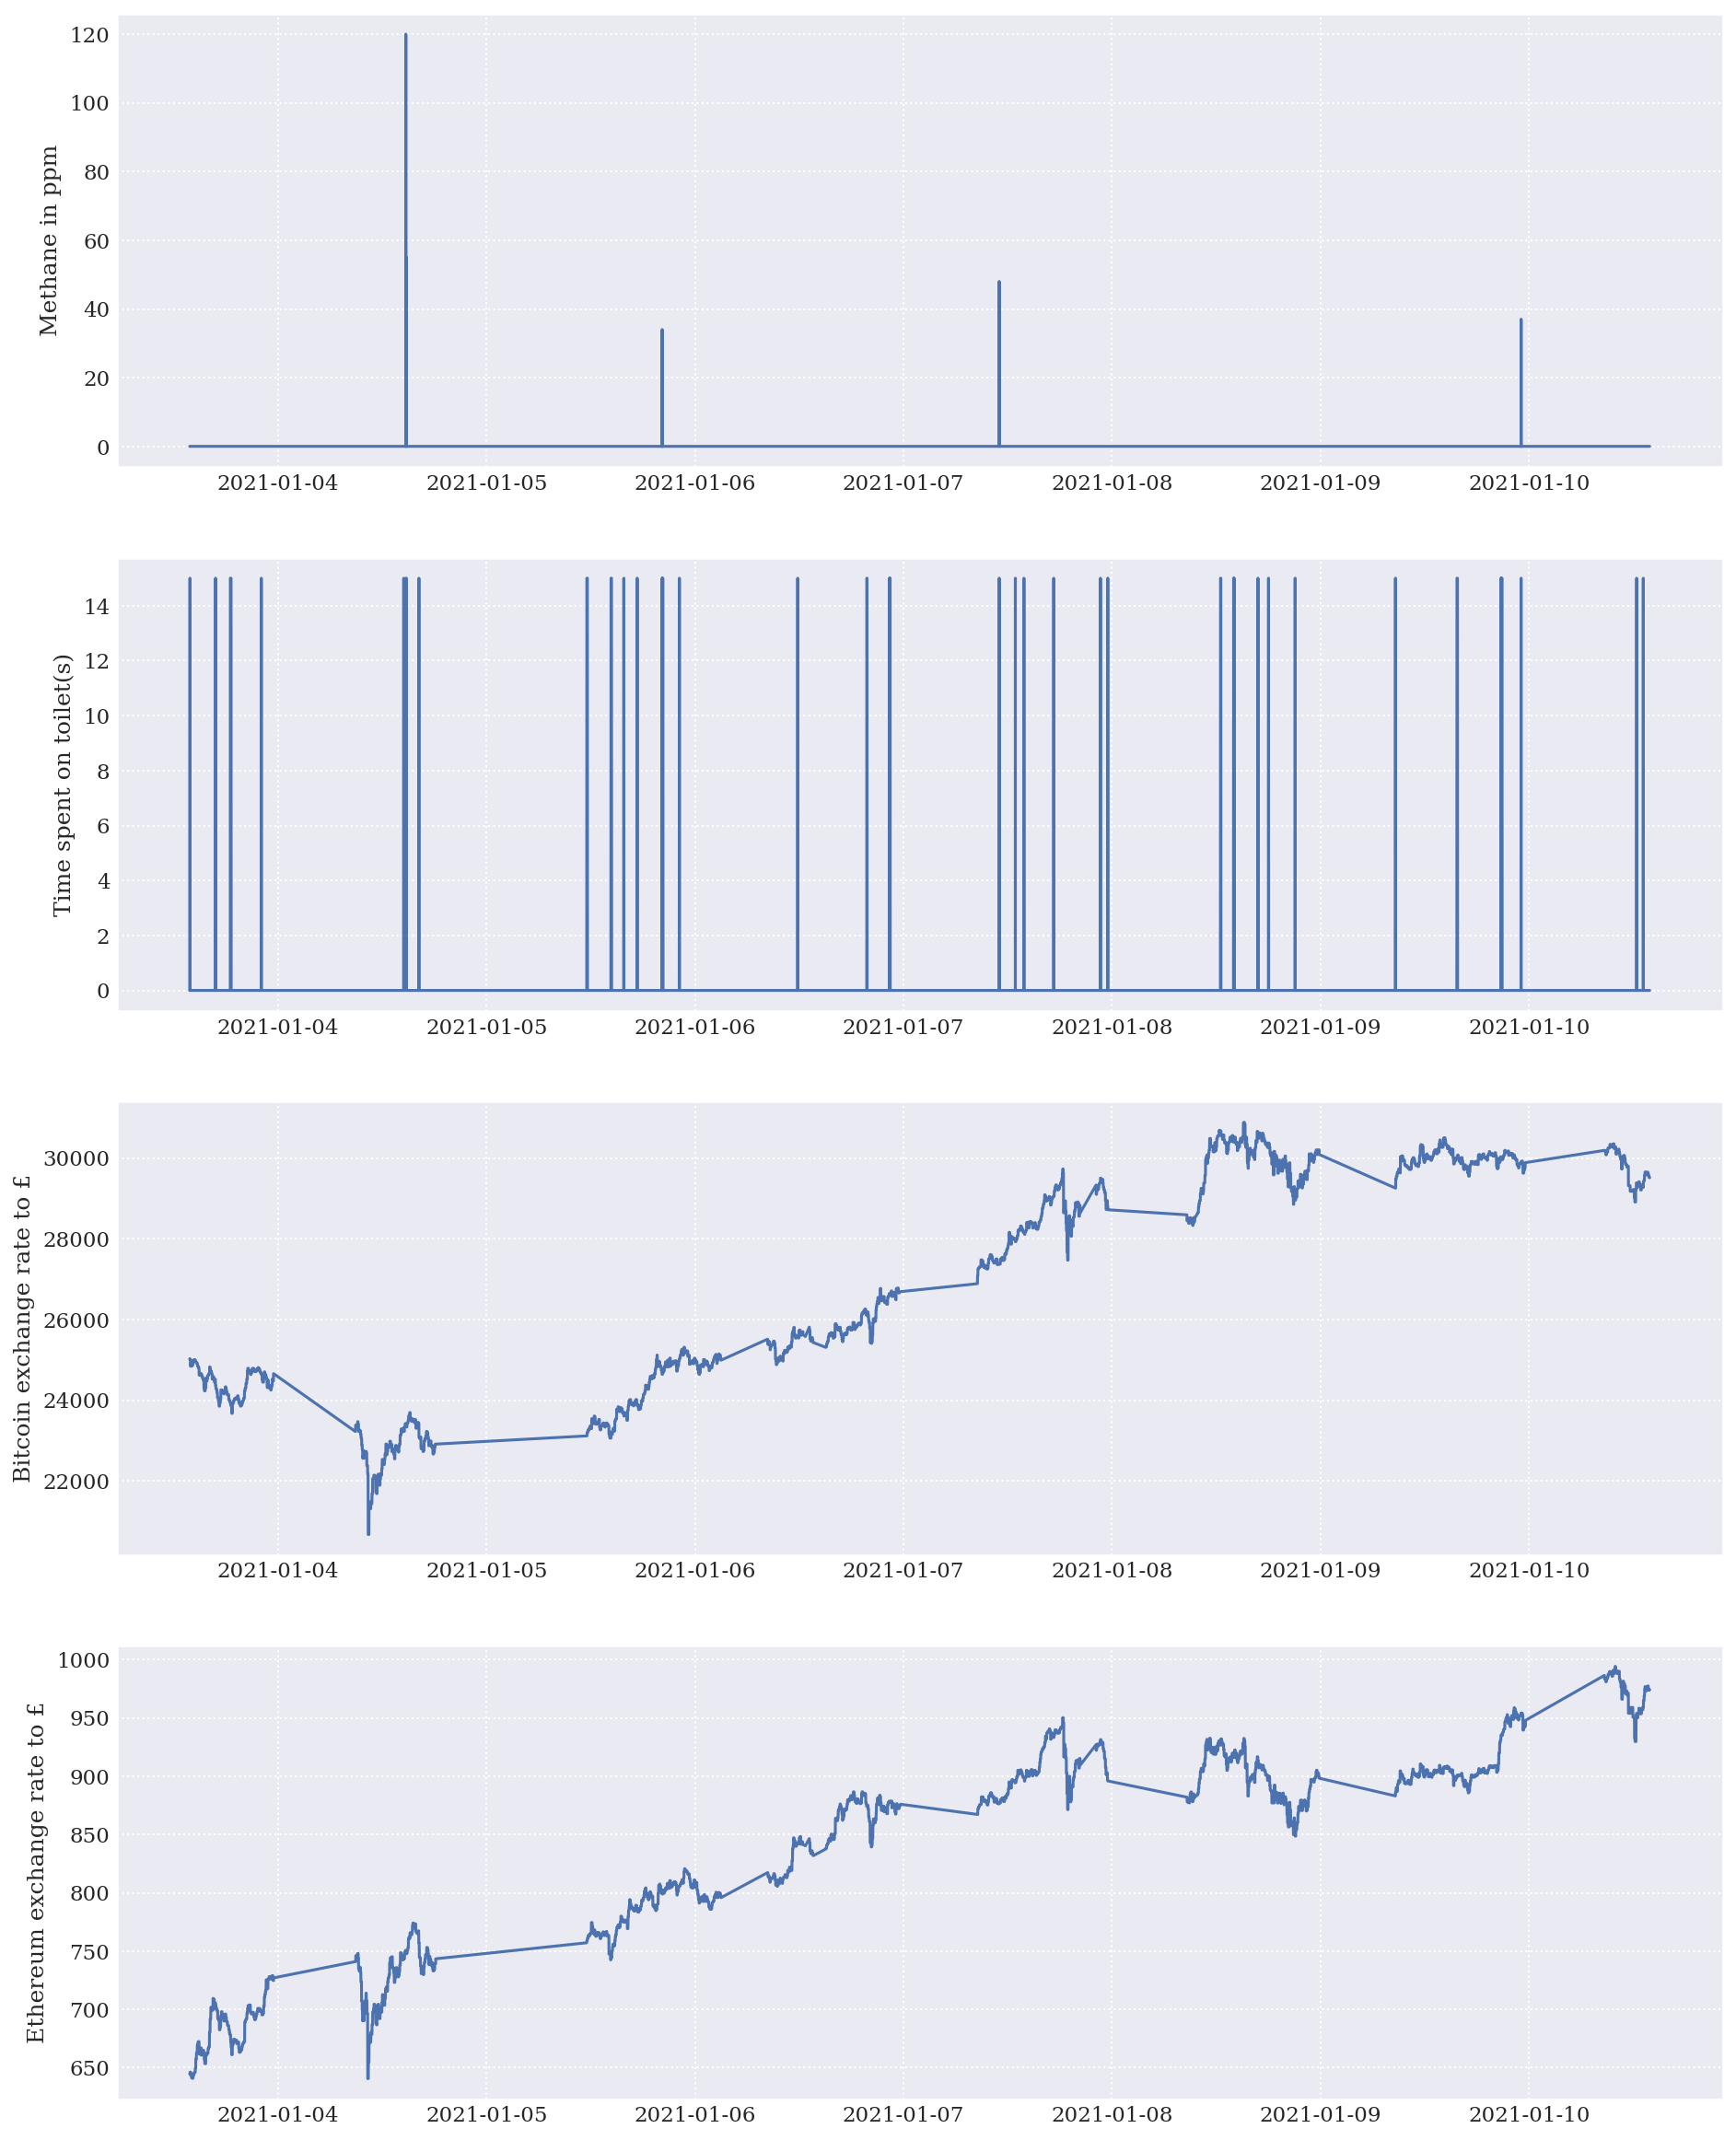

In [761]:
fig, ax = newfigure(4, figsize=(15,20))

ax[0].plot(toilet['ch4'])
ax[0].set_ylabel("Methane in ppm")

ax[1].plot(toilet['duration'])
ax[1].set_ylabel("Time spent on toilet(s)")

ax[2].plot(toilet['btc'])
ax[2].set_ylabel("Bitcoin exchange rate to £")

ax[3].plot(toilet['eth'])
ax[3].set_ylabel("Ethereum exchange rate to £")


plt.savefig('initialplots.png', dpi=300, bbox_inches='tight')
plt.show()


Using the sum of time spent on the toilet each hour, we can start to see how long on each day of the month I spent on the toilet per hour. There was one day where the data collection ran until 2 in the morning however values those have been dropped from the dataset. 

# Data analysis for correlation


Toilet duration values i.e. time spent on the toilet split into multiple events/visits, are produced by summing the durations between hours of the day e.g. how long was spent on the toilet betwen 8-9am, 9-10am and so on.


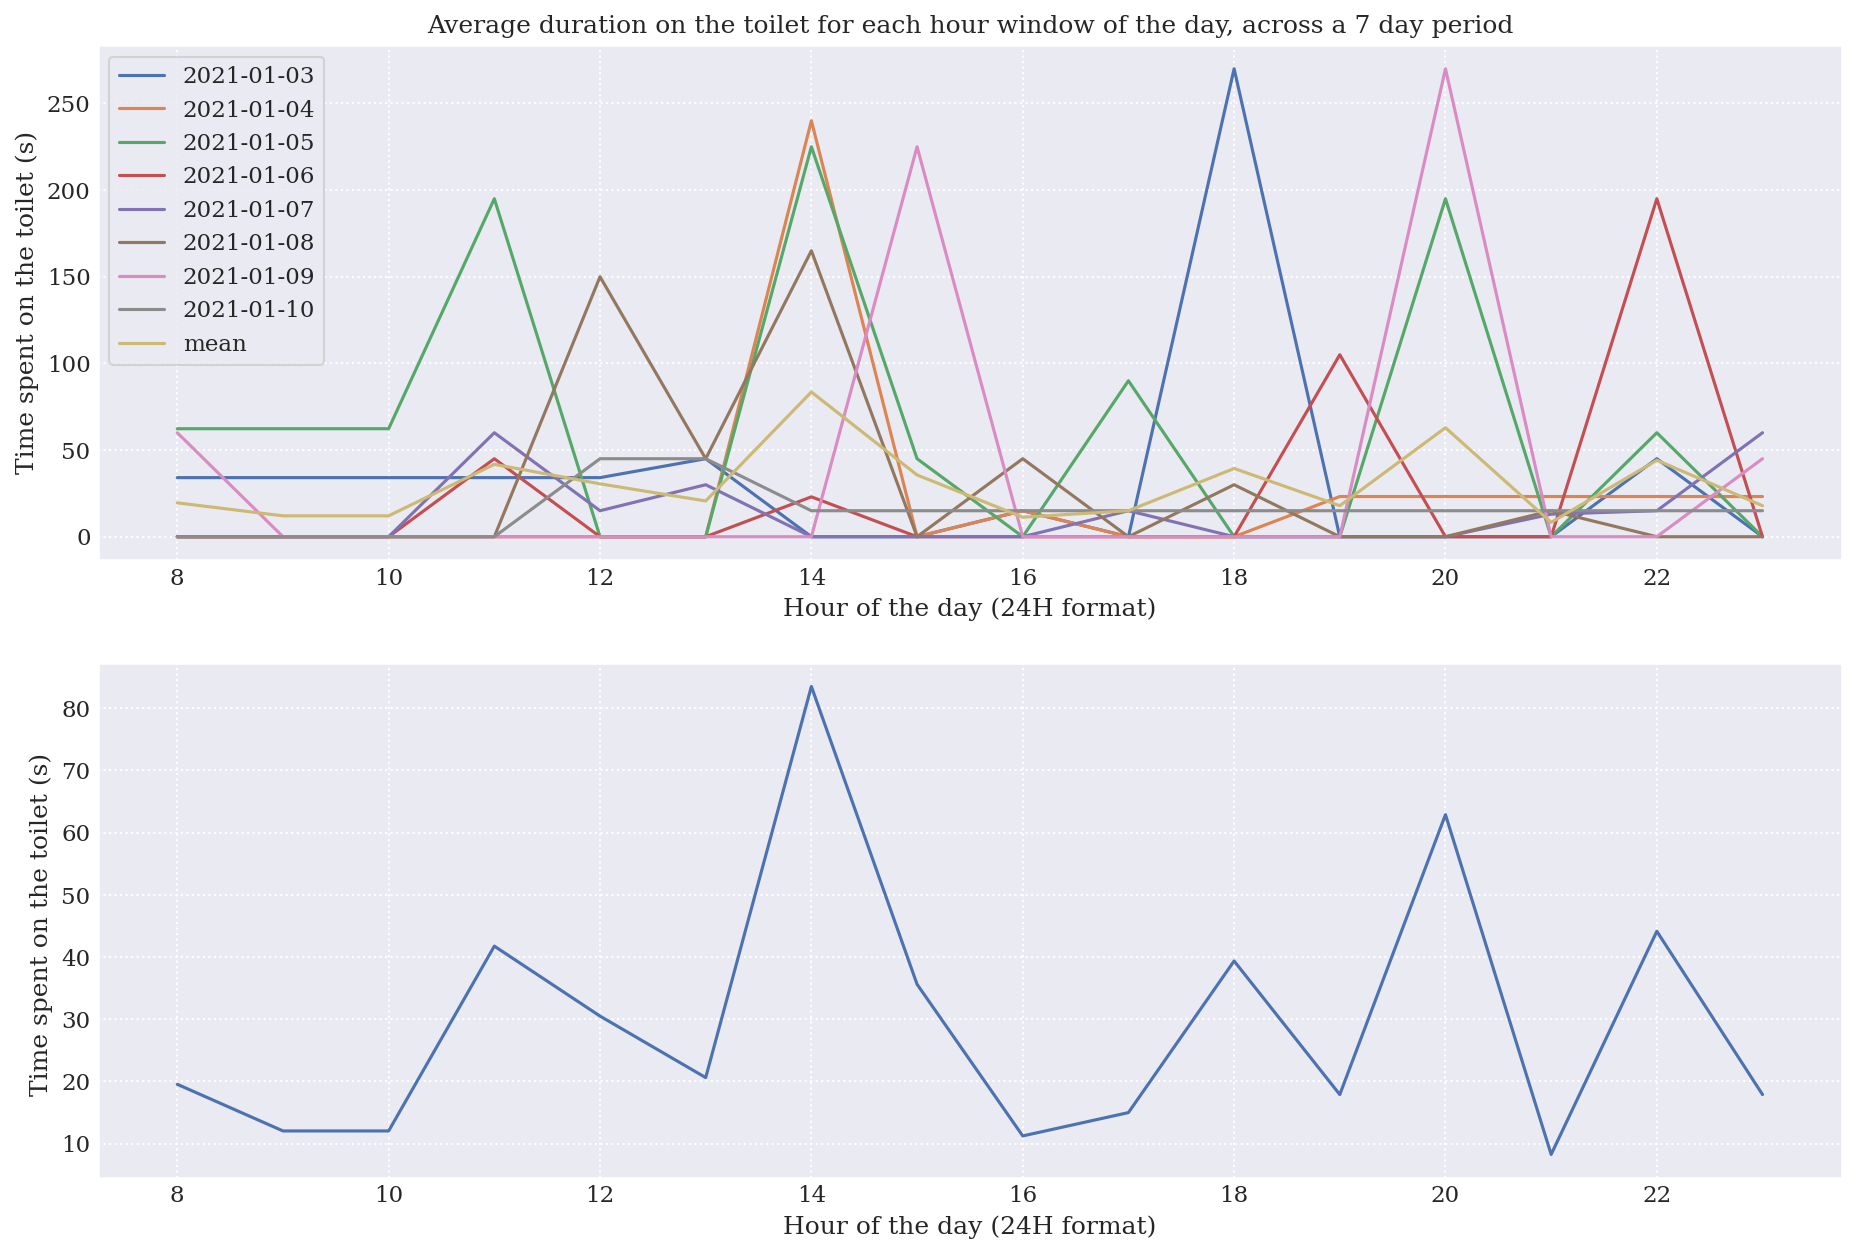

In [762]:
new_index = ['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', 'mean']

weekview = toilet.groupby([toilet['Hour'], toilet['Date']])['duration'].sum().reset_index()
weekview = weekview.pivot(index = 'Hour', columns ='Date', values = 'duration')
rowsToDrop = [0,1,2]
weekview.columns = date_index
weekview = weekview.drop(rowsToDrop)
toilet_column_means = weekview.mean()
weekview = weekview.fillna(toilet_column_means)

weekview['mean'] = weekview.mean(axis=1)

fig, ax = newfigure(2, figsize=(15,10))

ax[0].plot(weekview)
ax[0].set_ylabel("Time spent on the toilet (s)")
ax[0].set_xlabel("Hour of the day (24H format)")
ax[0].legend(new_index)
ax[0].set_title('Average duration on the toilet for each hour window of the day, across a 7 day period')


ax[1].plot(weekview['mean'])
ax[1].set_ylabel("Time spent on the toilet (s) ")
ax[1].set_xlabel("Hour of the day (24H format)")


plt.savefig('toiletdur.png', dpi=300, bbox_inches='tight')

plt.show()

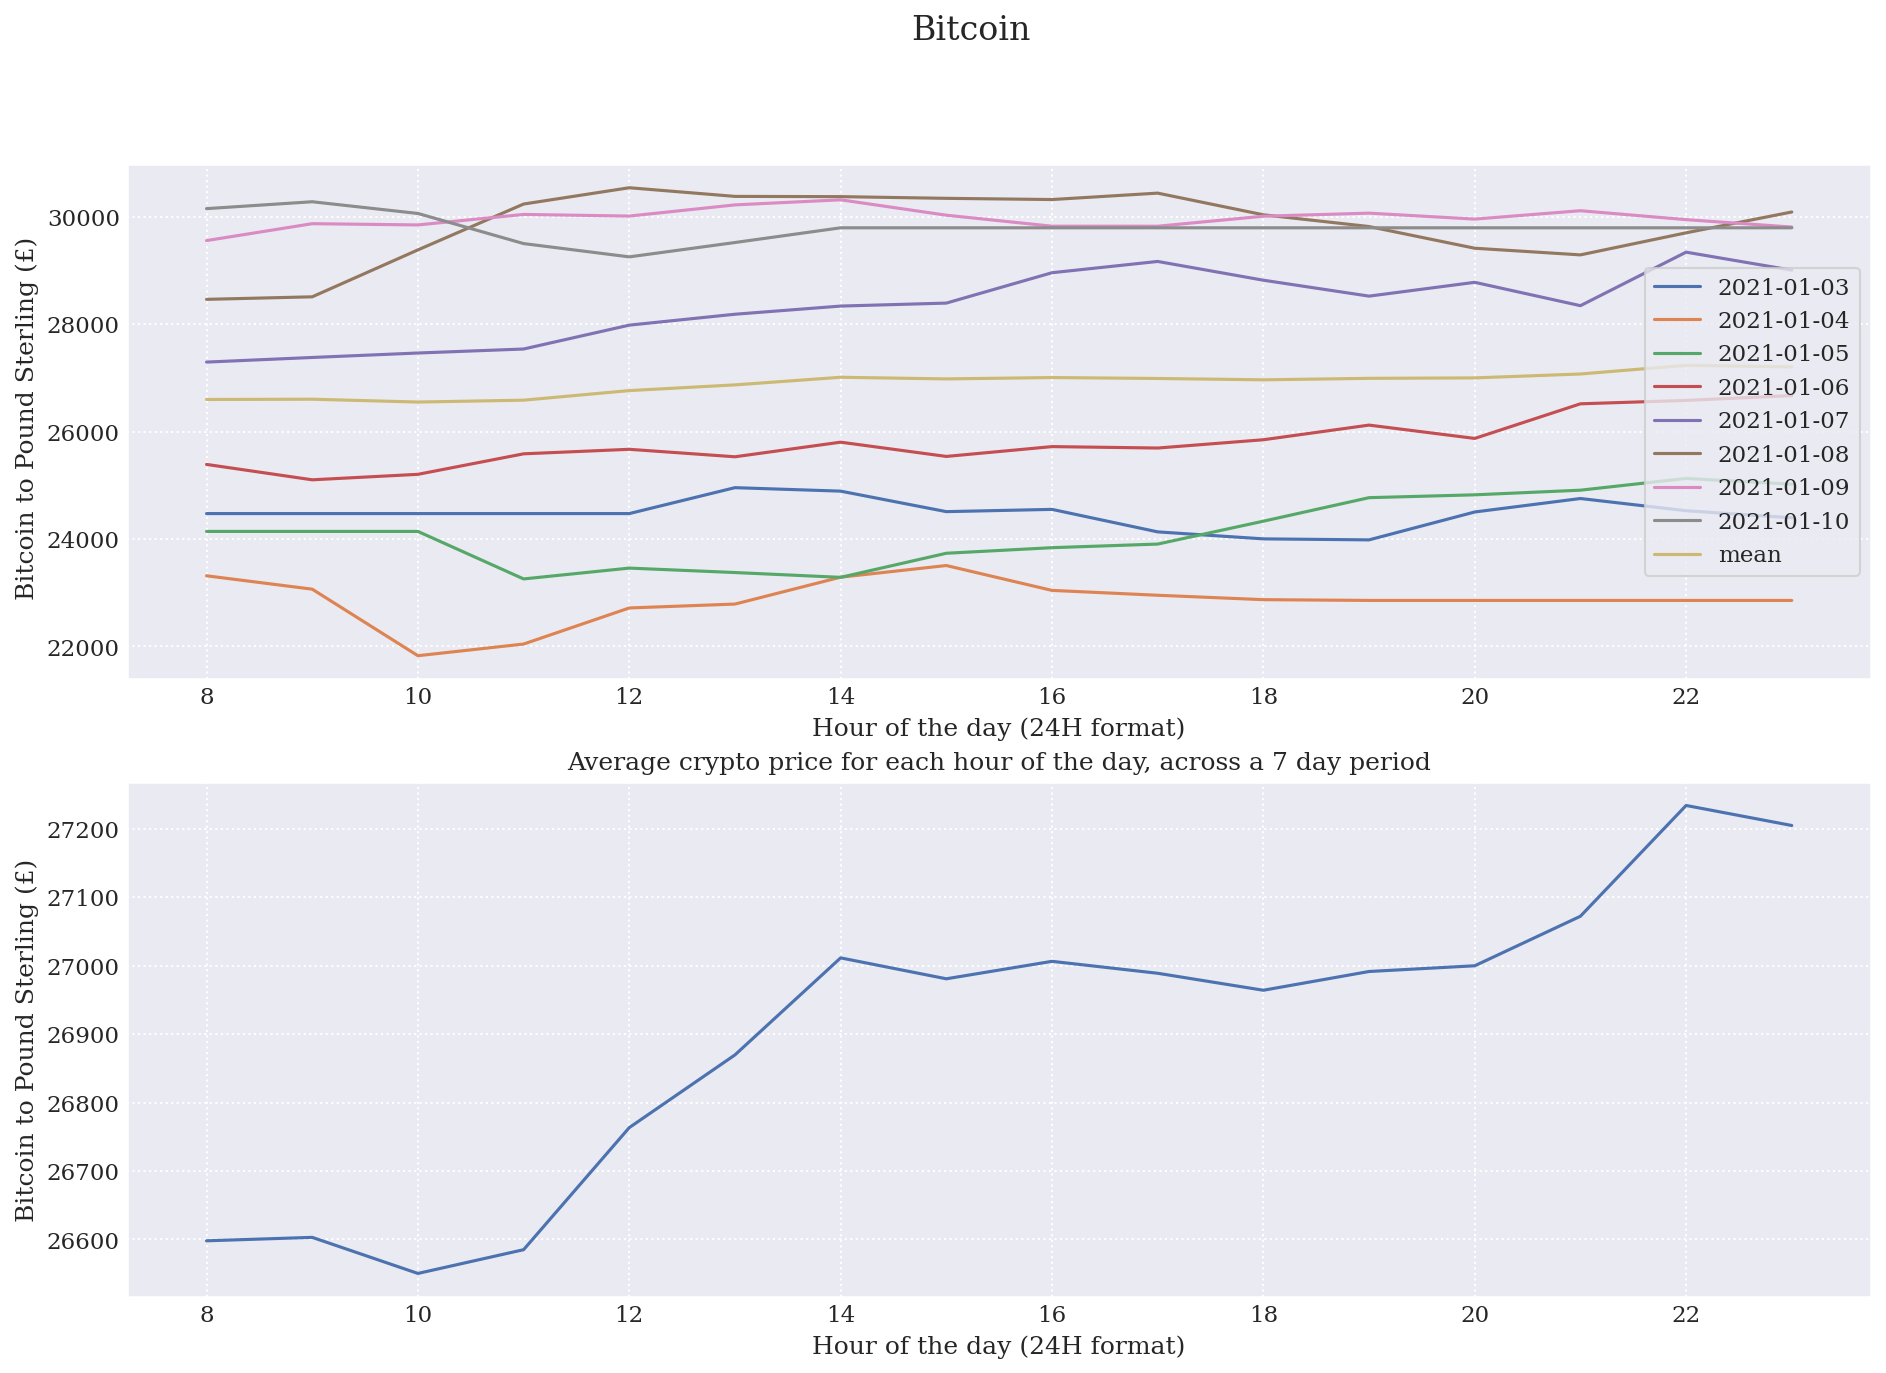

In [763]:
cryptoHR = toilet.groupby([toilet['Hour'], toilet['Date']])['btc'].mean().reset_index()
cryptoHR = cryptoHR.pivot(index = 'Hour', columns ='Date', values = 'btc')
rows = [0,1,2]
cryptoHR = cryptoHR.drop(rows)
cryptoHR.columns = date_index
crypto_column_means = cryptoHR.mean()
cryptoHR = cryptoHR.fillna(crypto_column_means)

cryptoHR['mean'] = cryptoHR.mean(axis=1)



fig, ax = newfigure(2, figsize=(15,10))

ax[0].plot(cryptoHR)
ax[0].set_ylabel(" Bitcoin to Pound Sterling (£)")
ax[0].set_xlabel("Hour of the day (24H format)")
ax[0].legend(new_index)
fig.suptitle('Bitcoin', fontsize=16)


ax[1].plot(cryptoHR['mean'])
ax[1].set_ylabel("Bitcoin to Pound Sterling (£)")
ax[1].set_xlabel("Hour of the day (24H format)")
ax[1].set_title('Average crypto price for each hour of the day, across a 7 day period')



plt.savefig('bitcoin.png', dpi=300, bbox_inches='tight')

plt.show()

# Pearson cross correlation

Once the toilet data and Bitcoin data were in the same format as a mean value for a time of day, they could then be compared to see if there was any correlation

In [764]:
weekview['mean'].corr(cryptoHR['mean'])

0.21052905741867026

This low value of 0.211 means there is little to no correlation between the datasets

# Export cleaned up data for publishing to Web App

In [765]:

weekview.to_csv('/Users/jordankotler/Desktop/siotWebApp/data/toiletusage.csv')
cryptoHR.to_csv('/Users/jordankotler/Desktop/siotWebApp/data/cryptodata.csv')

